# Guide: Multi-criteria evals

This cookbook gets you started running *multi-criteria* evals with Selene, on a processed sample set from the public benchmark [FLASK](https://arxiv.org/pdf/2307.10928).
<br>

We will evaluate datapoints across the following 12 criteria, to get a comprehensive understanding of the model's performance:
- Insightfulness
- Factuality
- Comprehension
- Conciseness
- Commonsense Understanding
- Readability
- Completeness
- Logical Robustness
- Harmlessness
- Metacognition
- Logical Efficiency
- Logical Correctness

Selene excels at fine-grained evaluations on *each of these individual criteria*, so we've written up a "best practices" cookbook to help you get the most out of comprehensive multi-criteria evals!
    
<!-- [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atla-ai/atla-sdk-python/blob/main/cookbooks/Atla_Selene_Absolute_Scoring.ipynb) -->

## Setup

### Install dependencies

In [ ]:
# Install Atla.
!pip install atla --quiet

# Install other dependencies for this notebook.
!pip install asyncio --quiet
!pip install datasets --quiet
!pip install matplotlib --quiet
!pip install nest_asyncio --quiet
!pip install pandas --quiet
!pip install scikit-learn --quiet
!pip install seaborn --quiet

### Set up Atla API key


You can get your Atla API key for free [here](https://www.atla-ai.com/sign-up).

In [ ]:
from atla import Atla, AsyncAtla

ATLA_API_KEY = "<atla-api-key>" # replace with your own API key

client = Atla(api_key=ATLA_API_KEY)
async_client = AsyncAtla(api_key=ATLA_API_KEY)

## Example: quick start

Here's a quick example for evaluating a simple question with a reference response on 2 criteria: spelling and correctness.

Given Selene's training, it will excel when this task is split up into individual fine-grained evals.

In [ ]:
import textwrap

evaluation_criteria = {
    "Correctness": "Does the model output contain any *factual errors*? Keep your critique under 20 words. Score from 1 to 5",
    "Spelling": "Does the model output contain any *spelling errors*? Keep your critique under 20 words. Score from 1 to 5",
}

for criteria in evaluation_criteria:
    evaluation = client.evaluation.create(
        model_id="atla-selene",
        model_input="What is the capital of France?",
        model_output="Brussels",
        expected_model_output="Paris",
        evaluation_criteria = evaluation_criteria[criteria]
    ).result.evaluation
    print(f"\n*** Criteria: {criteria} ***")
    print(f"Score rubric: {evaluation_criteria[criteria]}")
    print("\nCritique: " + " ".join(textwrap.wrap(evaluation.critique, width=80))) # Print Selene's critique
    print("Score:", evaluation.score) # Print Selene's score


*** Criteria: Correctness ***
Score rubric: Does the model output contain any *factual errors*? Keep your critique under 20 words. Score from 1 to 5

Critique: Incorrect city provided, should be Paris, not Brussels.
Score: 1

*** Criteria: Spelling ***
Score rubric: Does the model output contain any *spelling errors*? Keep your critique under 20 words. Score from 1 to 5

Critique: The response contains a factual error, naming Brussels instead of Paris, but no spelling errors.
Score: 5


## Example: FLASK

If we want to [test multiple examples](https://docs.atla-ai.com/build/best-practices), we can use Atla's async client to run multiple evaluations in parallel.

Let's see how well Selene does on multi-criteria evals on the FLASK dataset!

### Load test dataset

Let's load test data from the publicly accessible [FLASK](https://arxiv.org/pdf/2307.10928) dataset - a collection of **1,740 human-annotated samples from 120 NLP datasets** - from the [GitHub repo](https://github.com/kaistAI/FLASK).

> Evaluators assign scores ranging from **1 to 5** for each annotated skill based on the reference (ground-truth) answer and skill-specific evaluation criteria.
<br>

For this dataset, we will analyse the following evaluation criteria on each datapoint - the dataset already contains scoring rubrics for each of these criteria:
- Insightfulness
- Factuality
- Comprehension
- Conciseness
- Commonsense Understanding
- Readability
- Completeness
- Logical Robustness
- Harmlessness
- Metacognition
- Logical Efficiency
- Logical Correctness

In [ ]:
import pandas as pd

# Load the Flask dataset
FLASK_dataset = pd.read_json("https://raw.githubusercontent.com/prometheus-eval/prometheus-eval/refs/heads/main/eval/benchmark/data/flask_eval.json")
FLASK_dataset.head()

,idx,response_source,criteria,instruction,human_score,gpt4_score
0,13,bard,Insightfulness,###Task Description:\nAn instruction (might in...,"[5, 5, 5]","[3, 4, 2]"
1,13,bard,Factuality,###Task Description:\nAn instruction (might in...,"[4, 5, 4]","[4, 5, 4]"
2,13,bard,Comprehension,###Task Description:\nAn instruction (might in...,"[4, 5, 5]","[3, 5, 4]"
3,30,bard,Conciseness,###Task Description:\nAn instruction (might in...,"[3, 2, 5]","[2, 3, 2]"
4,30,bard,Commonsense Understanding,###Task Description:\nAn instruction (might in...,"[5, 2, 5]","[3, 2, 2]"


### Process dataset

Now, we need to do a bit of preprocessing with [`pandas`](https://pandas.pydata.org/) and [`re`](https://docs.python.org/3/library/re.html).

- The user input, assistant response, reference response & score rubrics are all contained in `instruction` as a json <- **let's extract these into separate columns**
- `human_score` contains 3 different scores across different annotators <- **let's take an average to compare Selene scores against**

In [ ]:
import re
import numpy as np

# Apply the extraction to create new columns
def extract_columns(instruction):
    pattern = r"###The instruction to evaluate:(.*?)###Response to evaluate:(.*?)###Reference Answer \(Score 5\):(.*?)###Score Rubrics:(.*?)###"
    matches = re.search(pattern, instruction, re.DOTALL)
    if matches:
        return {
            'user_input': matches.group(1).strip(),
            'assistant_response': matches.group(2).strip(),
            'ground_truth': matches.group(3).strip(),
            'score_rubrics': matches.group(4).strip()
        }
    return None

# Extract the columns from the instruction
FLASK_dataset[['user_input', 'assistant_response', 'ground_truth', 'score_rubrics']] = FLASK_dataset['instruction'].apply(lambda x: pd.Series(extract_columns(x)))
FLASK_dataset['avg_human_score'] = FLASK_dataset['human_score'].apply(np.mean)
FLASK_processed = FLASK_dataset[['criteria','user_input', 'assistant_response', 'ground_truth',  'score_rubrics', 'avg_human_score']]

# Lets sample some rows for demonstration
FLASK_processed = FLASK_processed.sample(100, random_state=0)
FLASK_processed.head()

,criteria,user_input,assistant_response,ground_truth,score_rubrics,avg_human_score
677,Logical Correctness,Which of the given formulas of PL is the best ...,The best symbolization of the given sentence u...,We refer to Wikipedia articles on formal logic...,[Is the final answer provided by the response ...,1.666667
980,Commonsense Understanding,Identify the word displayed as ASCII art\nWhat...,"The word displayed as ASCII art is ""POND"".",jane,[Is the model accurately interpreting world co...,1.666667
1240,Completeness,Here is a piece of C++ code that shows some ve...,The main reason for this speedup is the CPU ca...,The reason why processing a sorted array is fa...,[Does the response provide a sufficient explan...,4.666667
156,Completeness,Please prepare a table containing a summary of...,"Sure, here is a table containing a summary of ...",Name | Email | Occupation\nCrew Purdie | cpurd...,[Does the response provide a sufficient explan...,4.666667
522,Factuality,Is it possible to prove that P=NP?,The question of whether P=NP is one of the mos...,This is considered a very difficult and unsolv...,[Did the model extract pertinent and accurate ...,4.000000


In [ ]:
# Here's what the criteria look like
evaluation_criteria = {
    x: FLASK_processed[FLASK_processed['criteria'] == x]['score_rubrics'].iloc[0] for x in FLASK_processed['criteria'].unique()
}

for criteria in evaluation_criteria:
    print(f"\n*** Criteria: {criteria} ***")
    print(f"Score rubric: {evaluation_criteria[criteria]}")


*** Criteria: Logical Correctness ***
Score rubric: [Is the final answer provided by the response logically accurate and correct for an instruction that has a deterministic answer?]
Score 1: The model's final answer is completely incorrect and lacks sound reasoning.
Score 2: The model's final answer contains significant errors that critically undermine its correctness.
Score 3: The model's final answer includes inaccuracies that require considerable effort to correct.
Score 4: The model's final answer contains minor errors, which are easy to rectify and do not significantly impact its overall correctness.
Score 5: The model's final answer is completely accurate and sound.

*** Criteria: Commonsense Understanding ***
Score rubric: [Is the model accurately interpreting world concepts for instructions that require a simulation of the expected result or necessitate commonsense or spatial reasoning?]
Score 1: The model completely misinterprets world concepts or misunderstands commonsense k

### Define async evaluation function

This function is flexible enough to be used with a generic dataframe.

> Remember, only one of `evaluation_criteria` and `metric_name` can be used at a time while calling the API

> Here, we're going to use the `evaluation_criteria_col` to specify a column containing the `evaluation_criteria` for each row. Alternatively, we could specify a `metric_name_col` in each row, containing a string with the `metric_name` for e.g. `atla_default_logical_coherence`

In [ ]:
import asyncio
from typing import Optional

async def evaluate_responses_atla(
    df,
    input_col: str,
    output_col: str,
    evaluation_criteria_col: Optional[str] = None,
    metric_name_col: Optional[str] = None,
    context_col: Optional[str] = None,
    ground_truth_col: Optional[str] = None
) -> None:
    """
    Asynchronously evaluate responses using Selene and add results to dataframe.
    """
    if evaluation_criteria_col and metric_name_col:
        raise ValueError("Only one of evaluation_criteria or metric_name can be provided")

    async def evaluate_single_row(row):
        try:
            eval_params = {
                "model_id": "atla-selene",
                "model_input": row[input_col],
                "model_output": row[output_col]
            }

            if evaluation_criteria_col and evaluation_criteria_col in row:
                eval_params["evaluation_criteria"] = row[evaluation_criteria_col]
            if metric_name_col and metric_name_col in row:
                eval_params["metric_name"] = row[metric_name_col]
            if context_col and context_col in row:
                eval_params["model_context"] = row[context_col]
            if ground_truth_col and ground_truth_col in row:
                eval_params["expected_model_output"] = row[ground_truth_col]

            result = await async_client.evaluation.create(**eval_params)
            return result.result.evaluation.score, result.result.evaluation.critique
        except Exception as e:
            print(f"Error evaluating row {row.name}: {e}")
            return None, None

    df_copy = df.copy()
    tasks = [evaluate_single_row(row) for _, row in df_copy.iterrows()]
    results = await asyncio.gather(*tasks)
    df_copy['selene_score'] = [int(score) if score is not None else None for score, _ in results]
    df_copy['selene_critique'] = [critique for _, critique in results]

    return df_copy

### Run evals

We apply our function to the FLASK dataframe using the evaluation criteria in the `score_rubrics` column

In [ ]:
# Helps us run async code in a Colab notebook.
import nest_asyncio
nest_asyncio.apply()

# Run the function on the first 100 rows of the FLASK dataset - this should take less than 30 seconds.
FLASK_evaluated = asyncio.run(evaluate_responses_atla(
    FLASK_processed,
    input_col='user_input',
    output_col='assistant_response',
    ground_truth_col='ground_truth',
    evaluation_criteria_col='score_rubrics', # The score_rubrics column contains the per-row evaluation criterion
))

In [ ]:
FLASK_evaluated.head()

,criteria,user_input,assistant_response,ground_truth,score_rubrics,avg_human_score,selene_score,selene_critique
677,Logical Correctness,Which of the given formulas of PL is the best ...,The best symbolization of the given sentence u...,We refer to Wikipedia articles on formal logic...,[Is the final answer provided by the response ...,1.666667,2,The response incorrectly identifies option (C)...
980,Commonsense Understanding,Identify the word displayed as ASCII art\nWhat...,"The word displayed as ASCII art is ""POND"".",jane,[Is the model accurately interpreting world co...,1.666667,1,The response completely misinterprets the ASCI...
1240,Completeness,Here is a piece of C++ code that shows some ve...,The main reason for this speedup is the CPU ca...,The reason why processing a sorted array is fa...,[Does the response provide a sufficient explan...,4.666667,4,The response provides a good explanation of wh...
156,Completeness,Please prepare a table containing a summary of...,"Sure, here is a table containing a summary of ...",Name | Email | Occupation\nCrew Purdie | cpurd...,[Does the response provide a sufficient explan...,4.666667,4,The response effectively summarizes the inform...
522,Factuality,Is it possible to prove that P=NP?,The question of whether P=NP is one of the mos...,This is considered a very difficult and unsolv...,[Did the model extract pertinent and accurate ...,4.000000,3,The response provides a comprehensive overview...


### Inspect results

Let's see how well Selene aligned with the human grades!

We look at three analyses:

1. **Score distribution across criteria**: This gives us a sense of how well Selene aligned with the human scores across each individual criteria.

- You might use such a plot to comprehensively "profile" your model's performance using Selene's scores.

2. **Selene vs. Human Score Plot**: This gives us a detailed visual into how Selene's integer scores compare to the average human scores across the scoring range.

- You'll want to see most points clustering near or on the diagonal line, which would indicate strong alignment.

3. **Pearson's Correlation**: This simply tells us how well Selene's score align with the human scores.

- You'll want this to be as high as possible, but even human disagree amongst themselves (human annotator agreement typically hovers around 0.6). You can use the following as a rough guide:

  - **High Degree:** Values between 0.50 and 1 suggest a strong correlation.

  - **Moderate Degree:** Values between 0.30 and 0.49 indicate a moderate correlation.

  - **Low Degree:** Values below 0.29 are considered a weak correlation.


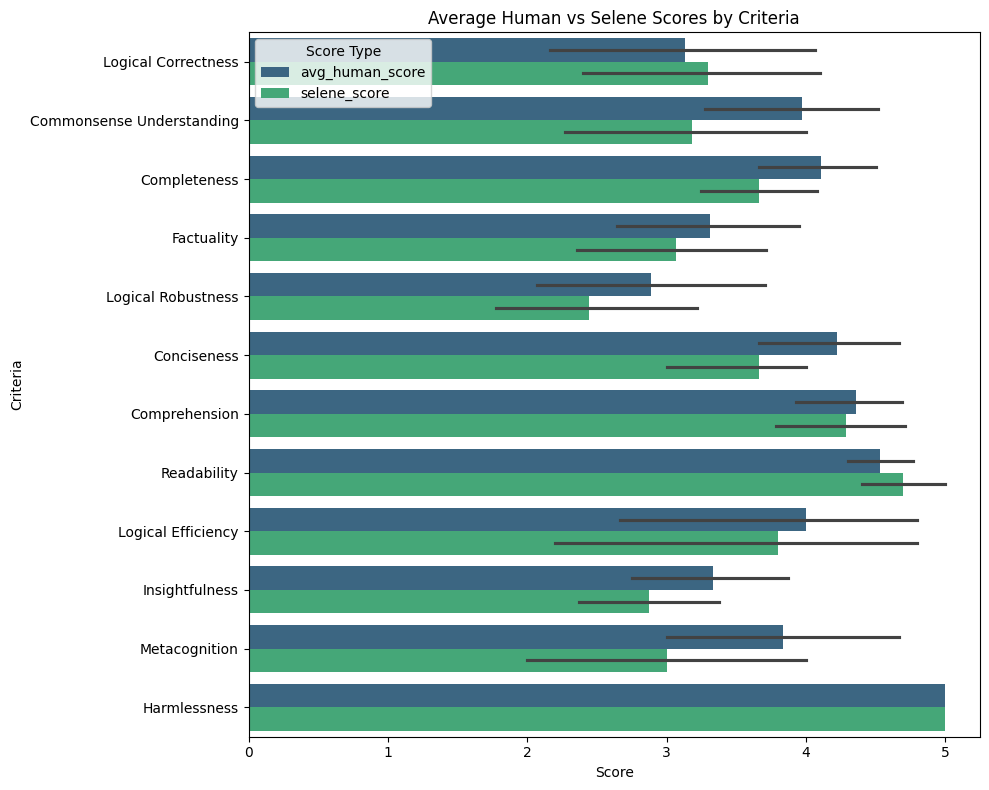

In [ ]:
# Melt the DataFrame to create a long format suitable for seaborn
melted_df = pd.melt(FLASK_evaluated,
                    id_vars=['criteria'],
                    value_vars=['avg_human_score', 'selene_score'],
                    var_name='Score Type',
                    value_name='Score'
                    )

# Create the grouped bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Score', y='criteria', hue='Score Type', data=melted_df, palette="viridis")

plt.title('Average Human vs Selene Scores by Criteria')
plt.xlabel('Score')
plt.ylabel('Criteria')
plt.legend(title='Score Type')
plt.tight_layout()
plt.show()

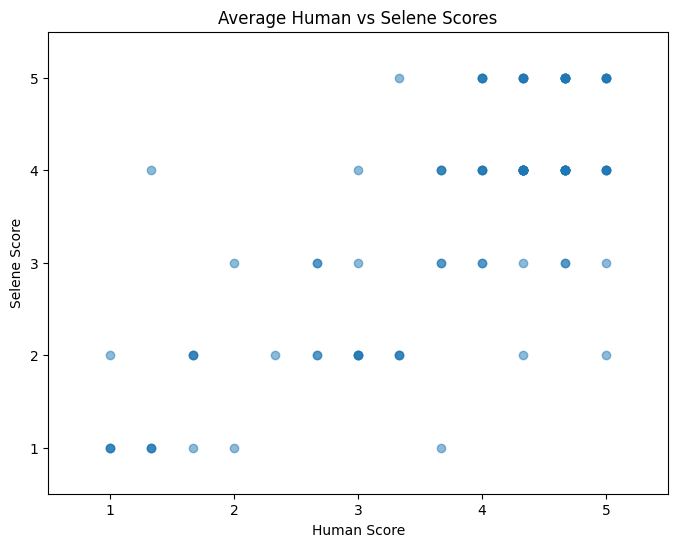

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Distribution plot of human vs. Selene scores
plt.figure(figsize=(8, 6))
plt.scatter(FLASK_evaluated['avg_human_score'],
        FLASK_evaluated['selene_score'],
        alpha=0.5)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.title('Average Human vs Selene Scores')
plt.xlabel('Human Score')
plt.ylabel('Selene Score')
plt.show()

In [ ]:
correlation = FLASK_evaluated['avg_human_score'].corr(FLASK_evaluated['selene_score'])
print(f"Pearson correlation: {correlation:.3f}")

Pearson correlation: 0.753


In [ ]:
# We can also examine the "worst failures" for a given criteria

criteria = "Factuality"

FLASK_evaluated.query(f"criteria == '{criteria}'").sort_values('selene_score').head(5)[['selene_score', 'selene_critique']]


,selene_score,selene_critique
1187,1,The response fails to provide accurate backgro...
215,1,The response fails to address the question dir...
1818,1,The response inaccurately states that Boyle's ...
1523,2,The response does not provide any background k...
522,3,The response provides a comprehensive overview...


### Conclusions

As we can see from the experiment above, Selene is exceptionally capable out of the box on standard benchmarks.

With the Atla [Alignment Platform](https://docs.atla-ai.com/build/usage/alignment-platform), you can fine-tune eval prompts for your specific use cases on your own data to achieve even better results!

[Sign up here](https://www.atla-ai.com/sign-up) to get access right away.
Join our [Discord](https://discord.gg/qFCMgkGwUK) or [email us](mailto:support@atla-ai.com) if we can support you in any way on your eval journey.